In [1]:
import pandas as pd
from pandas_profiling import ProfileReport
import sys
!pip install matplotlib
!pip install graphviz

<ipython-input-1-0e96e7604878>:2: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


In [70]:
data = pd.read_csv(r'C:\Users\Never\Downloads\Customer-Churn-Records.csv')
for col in data.columns:
  if data[col].dtype=='object':
    #making sure data is not read as bytes but as string values from a file
    data[col] = data[col].str.decode('utf-8')

Getting report of data info by pandas profiling

In [3]:
profile = data.profile_report()
profile.to_file(r'C:\Users\Never\Downloads\profile_report.html')



Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [71]:
summary=data.describe()
print(summary)

         RowNumber    CustomerId  Surname   CreditScore  Geography  Gender  \
count  10000.00000  1.000000e+04      0.0  10000.000000        0.0     0.0   
mean    5000.50000  1.569094e+07      NaN    650.528800        NaN     NaN   
std     2886.89568  7.193619e+04      NaN     96.653299        NaN     NaN   
min        1.00000  1.556570e+07      NaN    350.000000        NaN     NaN   
25%     2500.75000  1.562853e+07      NaN    584.000000        NaN     NaN   
50%     5000.50000  1.569074e+07      NaN    652.000000        NaN     NaN   
75%     7500.25000  1.575323e+07      NaN    718.000000        NaN     NaN   
max    10000.00000  1.581569e+07      NaN    850.000000        NaN     NaN   

                Age        Tenure        Balance  NumOfProducts    HasCrCard  \
count  10000.000000  10000.000000   10000.000000   10000.000000  10000.00000   
mean      38.921800      5.012800   76485.889288       1.530200      0.70550   
std       10.487806      2.892174   62397.405202       0.

In [72]:
#drop variable
data=data.drop(columns=['RowNumber'])
data=data.drop(columns=['CustomerId'])
data=data.drop(columns=['Surname'])

In [73]:
#create a list for categorical columns
cat_cols=["Geography","Gender","Card Type"]

In [76]:
#create a copy of data frame
df_onehot=data.copy()
#conver categorical variable to dummy
df_onehot=pd.get_dummies(data, columns=cat_cols, prefix=cat_cols)
#print dataset
df_onehot
import numpy as np
print(" \nCount total NaN in a DataFrame : \n\n",
       df_onehot.isnull().sum().sum())


 
Count total NaN in a DataFrame : 

 0


In [37]:
#train test set split
from sklearn.model_selection import train_test_split
class_col_name="Exited"
one_hot_feature_names=df_onehot.columns[df_onehot.columns !=class_col_name]
#split dataset into training set and test set
x_train, x_test, y_train, y_test = train_test_split(df_onehot.loc[:,  one_hot_feature_names], df_onehot[class_col_name], test_size=0.2, random_state=45)

Decision Tree

class Names ['1' '0']


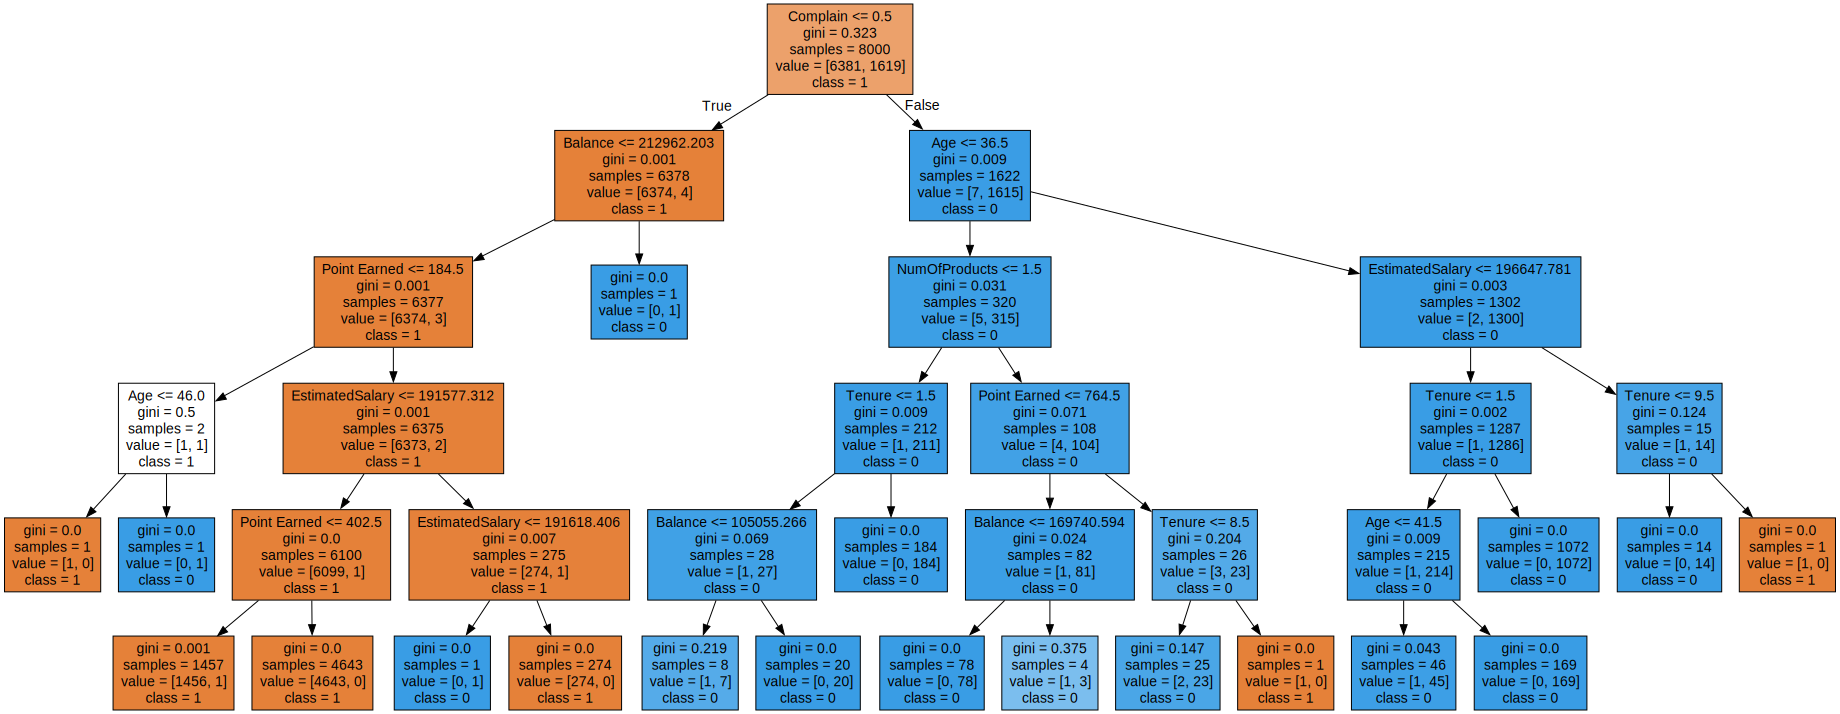

In [38]:
# Perform prediction on the test set
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=5)
clf = clf.fit(x_train, y_train)
import graphviz
y_pred = clf.predict(x_test)
#Get unique class values to display on the tree
class_values=df_onehot[class_col_name].unique()
class_values= class_values.astype(str)
print ("class Names",class_values)

dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=one_hot_feature_names,  
                                class_names=class_values,
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png")
graph

In [39]:
# Get classification report
from sklearn.metrics import classification_report
from sklearn import metrics

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1581
           1       0.99      1.00      0.99       419

    accuracy                           1.00      2000
   macro avg       0.99      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



Linear Regression

In [77]:
#remove outliers
import numpy as np
z_scores=np.abs((df_onehot-df_onehot.mean())/df_onehot.std())
threshold=3.0
outliers=df_onehot[z_scores>threshold]
df_onehot_no_outliers= df_onehot[z_scores<= threshold]

In [78]:
#normalization
numeric_cols =['CreditScore','Age','Tenure','Balance','NumOfProducts','EstimatedSalary','Point Earned']
df_onehot_no_outliers[numeric_cols] = (df_onehot_no_outliers[numeric_cols] - df_onehot_no_outliers[numeric_cols].min()) / (df_onehot_no_outliers[numeric_cols].max() - df_onehot_no_outliers[numeric_cols].min())
bank_data=df_onehot_no_outliers.copy()

In [81]:
#remove NAs
import numpy as np
print(" \nCount total NaN in a DataFrame : \n\n",
       bank_data.isnull().sum().sum())
bank_data=bank_data.dropna()
bank_data=bank_data.dropna(axis=1)

 
Count total NaN in a DataFrame : 

 0


In [82]:
#train test set split
from sklearn.model_selection import train_test_split
class_col_name="Exited"
one_hot_feature_names=bank_data.columns[bank_data.columns !=class_col_name]
#split dataset into training set and test set
X_train, X_test, Y_train, Y_test = train_test_split(bank_data.loc[:,  one_hot_feature_names], bank_data[class_col_name], test_size=0.2, random_state=45)

In [85]:
#linear regression
from sklearn.linear_model import LinearRegression
lr_model=LinearRegression()
lr_model.fit(X_train,Y_train)
lr_pred=lr_model.predict(X_test)
print("Intercept:", lr_model.intercept_)
print("Coefficients:", lr_model.coef_)
print("R-squared:", lr_model.score(X_train, Y_train))

Intercept: 0.0022248258677696198
Coefficients: [ 1.24896054e-03  8.81772047e-03 -1.10279037e-03 -2.68243509e-04
 -2.64292771e-03  4.67640096e-04 -2.68621700e-03 -2.43921272e-06
  9.92239327e-01 -3.32178265e-04 -3.64230018e-03]
R-squared: 0.9905334180867273


KNN alogarithm

In [90]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, Y_train)
knn_pred = knn_model.predict(X_test)
print("Number of neighbors:", knn_model.n_neighbors)
print("Weights:", knn_model.weights)

Number of neighbors: 5
Weights: uniform


In [92]:
from sklearn.metrics import confusion_matrix
knn_cm = confusion_matrix(Y_test, knn_pred)
print("Confusion Matrix (KNN):\n", knn_cm)

Confusion Matrix (KNN):
 [[1574    2]
 [   0  384]]


In [93]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
knn_acc = accuracy_score(Y_test, knn_pred)
knn_prec = precision_score(Y_test, knn_pred,average='weighted')
knn_rec = recall_score(Y_test, knn_pred,average='weighted')
print(f"Test Accuracy (KNN): {knn_acc:.3f}")
print(f"Precision(KNN): {knn_prec:.3f}")
print(f"Recall(KNN): {knn_rec:.3f}")


Test Accuracy (KNN): 0.999
Precision(KNN): 0.999
Recall(KNN): 0.999
